# Mesure de la synchronisation de mouvements de danse

Dans le cadre du projet de reconnaissance visuelle, nous aimerions comparer les mouvements de danseurs différents. En particulier, nous aimerons savoir si deux danseurs sont synchrones dans leurs mouvements pour une chorégraphie donnée. Cela nécessite un prétraitement de chaque frame d'une vidéo, puis d'identifier les différentes parties du corps de chaque danseurs, et enfin d'analyser les mouvements de chacune de ces parties. Dans ce notebook, nous allons traiter chacune de ces parties, en évitant au maximum le recours aux méthodes d'apprentissage automatique, mais en se fixant des contraintes sur le format de la vidéo.

In [1]:
original_video_path = "data/test_video_trimed.mp4"
processed_video_path = "data/chore_jo_wa_processed.mp4"

## I. Prétraitement des données: suppression du fond

In [3]:
import platform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from scipy import ndimage
from skimage.segmentation import active_contour
from skimage.draw import polygon
from IPython.display import clear_output
from time import sleep, time
from copy import deepcopy
from sklearn.cluster import KMeans

<h4>Loading Video</h4>

In [4]:
def load_video(vidFile):
    '''
    Reads the video
    :param vidFile: Video file
    :return: video sequence, frame rate, width & height of video frames
    '''
    print('Load video')
    vid = cv2.VideoCapture(vidFile)
    fr = vid.get(cv2.CAP_PROP_FPS)  # frame rate
    len = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vidWidth = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    vidHeight = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # save video as stack of images
    video_stack = np.empty((len, vidHeight, vidWidth, 3))

    for x in range(len):
        ret, frame = vid.read()

        video_stack[x] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        filename = "./data/Images/" + vidFile[7:-4] + "_" + str(x) + ".jpg"
        cv2.imwrite(filename, frame)

    vid.release()

    return video_stack, fr, vidWidth, vidHeight

def save_video(fr, video, output_file) : 
    # Define the video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also use other codecs such as 'XVID', 'MJPG', 'DIVX', etc.
    output_video = cv2.VideoWriter(output_file, fourcc, fr, (video[0].shape[1], video[0].shape[0]))  # Adjust FPS as needed (e.g., 25 FPS)

    # Write cropped_video to the video
    for frame in video:
        output_video.write(cv2.cvtColor(np.uint8(frame), cv2.COLOR_RGB2BGR))

    # Release the video writer
    output_video.release()

    print("Video saved successfully.")

def display(frames_list) :
    
    ln = len(frames_list)
    nb_frames = len(frames_list[0])
    print(ln, nb_frames)

    for i in range(nb_frames) : 
        
        fig, axs = plt.subplots(1, ln)
        
        for j in range(ln) :
            if frames_list[j][i].max()>1 : 
                axs[j].imshow(frames_list[j][i].astype(int)) 
            else : 
                axs[j].imshow(frames_list[j][i]) 
                
        plt.show()
        # sleep(0.001)
        clear_output(wait=True)

In [5]:
video_stack, fr, vidWidth, vidHeight = load_video(original_video_path)
video_stack.shape

Load video


(280, 696, 480, 3)

<h4>Background Substraction with actif contours method</h4>

In [10]:
def apply_mog(video) :
    
    fgbg = cv2.createBackgroundSubtractorMOG2()
    masks = []
    i = 0
    while(1):
        frame = video[i]

        fgmask = fgbg.apply(frame)
        masks.append(fgmask)

        if i<len(video)-1 :     
            i += 1
        else : 
            break
        
    return masks 

def motion_difference_masks(video) :
    
    diff_masks = []

    for i in range(len(video)-1) :
        
        diff_masks.append(np.uint8(255*(np.sum(np.abs(video[i]-video[i+1]), axis=2)>10)))
        
    diff_masks.append(diff_masks[-1])
    return diff_masks

def filter_masks(masks, kernel_size=4) :
    height, width = masks[0].shape
    num_frames = len(masks)
    filtered_masks = np.zeros((num_frames, height, width), dtype=np.uint8)
    
    for i in range(len(masks)) : 
        filtered_masks[i] = signal.convolve2d(filtered_masks[i], np.ones((10, 10)), mode='same')
        filtered_masks[i] = (filtered_masks[i]>0.5).astype(int)

    # Iterate over each pixel position
    for i in range(height):
        for j in range(width):
            # Extract pixel values across all frames
            pixel_values = masks[:, i, j]

            filtered_masks[:, i, j] = ndimage.median_filter(pixel_values, size=kernel_size)

    return filtered_masks

def fit_active_contour(masks) : 
    
    
    s = np.linspace(0, 2*np.pi, 1000)
    r = 400 + 600*np.sin(s)
    c = 200 + 600*np.cos(s)
    init = np.array([r, c]).T
    
    contours = []
    for i in range(len(masks)) :
        if not (i%1) : 
            start_tm = time()
            snake = active_contour(gaussian(masks[i], 5, preserve_range=False),
                                init, alpha=0.03, beta=1, gamma=0.001)
            contours.append(snake)
            # init = deepcopy(snake)
            print(f'Frame {i}; Execution time : ', time()-start_tm) 
        else : 
            contours.append(contours[-1])
        if i<10 : # Display the first 10 frames
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.imshow(masks[i].astype(int))
            # ax.imshow(masks[i], cmap=plt.cm.gray)
            ax.plot(contours[i][:, 1], contours[i][:, 0], '-b', lw=3)
            ax.set_xticks([]), ax.set_yticks([])
            ax.axis([0, masks[i].shape[1], masks[i].shape[0], 0])
            plt.show()
        clear_output(wait=True)
    return contours

def crop_video(video, contours) : 
    
    croped_video = []
    
    for i in range(len(video)) : 
        img = video[i].astype(int)
        # poly = np.roll(snake, 1, axis=1).astype(int).reshape(-1, 1, 2) 
        poly = contours[i].astype(int)

        rr, cc = polygon(poly[:, 0], poly[:, 1], img.shape)

        masked_img = 255*np.ones(img.shape)
        for i in range(3) : 
            masked_img[rr, cc, i] = img[rr, cc, i]
            
        croped_video.append(masked_img)
        
    return croped_video

In [8]:
def preprocess(video) : 
    
    # Compute the motion masks 
    diff_masks = motion_difference_masks(video)
    
    # Fit actif contours in each frames's mask 
    contours = fit_active_contour(diff_masks)    # This step can be optmized by fitting the countours 1/2 frames if motion not so fast 
    
    # Crop the video according to the found masks 
    cropped_video = crop_video(video, contours)
    
    return cropped_video, contours, diff_masks


In [11]:
cropped_video, contours, diff_masks =  preprocess(video_stack)

Frame 279; Execution time :  12.302750825881958


In [12]:
cropped_video = crop_video(video_stack, contours)

save_video(fr, cropped_video, processed_video_path)

Video saved successfully.


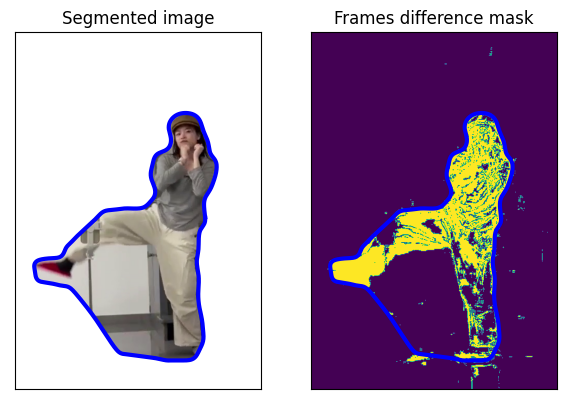

In [31]:
## Example results on one frame

id = 103

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(cropped_video[id].astype(int))
# ax.imshow(cropped_video[i], cmap=plt.cm.gray)
ax[0].plot(contours[id][:, 1], contours[id][:, 0], '-b', lw=3)
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].axis([0, cropped_video[id].shape[1], cropped_video[id].shape[0], 0])
ax[0].set_title('Segmented image')

ax[1].imshow(diff_masks[id])

ax[1].plot(contours[id][:, 1], contours[id][:, 0], '-b', lw=3)
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].axis([0, cropped_video[id].shape[1], cropped_video[id].shape[0], 0])
ax[1].set_title('Frames difference mask')

# ax[2].imshow(filtered_masks[:2][i])

plt.show()

## II. Reconnaissance des parties du corps et analyse du mouvement

Une fois le danseur bien rogné, nous nous plaçons dans le cadre bien précis où les parties du corps à identifier sont identifiés par le port d'un objet de couleurs distinctes. Dans notre cas, le port d'un chapeau kaki pour identifier le haut de la tête, et respectivement d'une chaussette rose et d'une chaussure rouge pour le pied gauche et le pied droit.  
Nous avons instauré ces contraintes dû à la difficulté de reconnaitre les parties du corps sans l'aide d'algorithme de deeplearning. En particulier, même en définissant les pieds comme étant les points les plus bas du rognage, le pied droit n'est pas nécessairement à droite et le pied gauche n'est pas nécessairement à gauche. Ces généralités sont d'autant plus fausses pour des chorégraphies de danse riches en positions. 

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Le code commenté ci-dessous a servi à identifier les fenêtres de couleur HSV des différents objets. Nous avons trouvé HSV ici plus adapté que RGB par exemple puisque la teinte de l'objet n'est pas supposée porter de variations importantes au cours de la vidéo, tandis que le contraste et la luminosité doivent varier davantage.

In [42]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def apply_hsv_filter(frame, lower_bound, upper_bound):
#     hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
#     # Créer un cadre vert
#     green_frame = np.zeros_like(frame)
#     green_frame[:, :] = (0, 255, 0)  # BGR pour le vert
    
#     # Utiliser le masque pour combiner le cadre vert et le cadre filtré
#     filtered_frame = cv2.bitwise_and(frame, frame, mask=mask)
#     final_frame = cv2.bitwise_or(filtered_frame, cv2.bitwise_and(green_frame, green_frame, mask=~mask))
    
#     return final_frame

# def display_frames(original_frame, filtered_frame):
#     # Concaténer les images horizontalement
#     output_frame = np.hstack((original_frame, filtered_frame))
#     # Afficher l'image
#     plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

# def process_video(input_file, lower_bound, upper_bound, mode='static'):
#     cap = cv2.VideoCapture(input_file)
    
#     if mode == 'static':
#         for _ in range(5):
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             filtered_frame = apply_hsv_filter(frame, lower_bound, upper_bound)
#             display_frames(frame, filtered_frame)
#     elif mode == 'video':
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             filtered_frame = apply_hsv_filter(frame, lower_bound, upper_bound)
#             display_frames(frame, filtered_frame)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
    
#     cap.release()
#     cv2.destroyAllWindows()

# # Paramètres HSV pour le filtrage
# lower_bound_fuchsia = np.array([140, 50, 100])
# upper_bound_fuchsia = np.array([170, 255, 255])

# lower_bound_red = np.array([170, 50, 100])
# upper_bound_red = np.array([179, 255, 255])

# lower_bound_brown = np.array([10, 70, 50])
# upper_bound_brown = np.array([30, 255, 100])

# # Mode d'exécution (statique ou vidéo)
# mode = 'video' 

# # Appel de la fonction pour traiter la vidéo avec les paramètres spécifiés
# process_video(processed_video_path, lower_bound_fuchsia, upper_bound_fuchsia, mode)


Nous définissons une première classe générique pour représenter chaque objet. Chaque objet est défini par le résultat du masque appliqué pour retrouver les pixels définis dans une fenêtre de couleurs HSV. Nous commençons par trouver les contours de ces zones là. Si la frame est très bruitée et contient des pixels "aléatoires" des teintes de notre fenêtre, ils seront éliminés puisque notre fonction find_objects ne prend en compte que le plus grand contour. Le barycentre est alors calculé pour cette zone, et fait office de coordonnées pour notre objet.

In [43]:
class Segmenter:
    def __init__(self, lower_bound, upper_bound, min_area=100, k=1):
        self.lower_bound = np.array(lower_bound)
        self.upper_bound = np.array(upper_bound)
        self.min_area = min_area
        self.k = k

    def convert_to_hsv(self, frame):
        return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    def apply_mask(self, frame):
        hsv = self.convert_to_hsv(frame)
        mask = cv2.inRange(hsv, self.lower_bound, self.upper_bound)
        mask = self.filter_small_masks(mask)
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        return binary_mask


    def filter_small_masks(self, mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filtered_mask = np.zeros_like(mask)
        for contour in contours:
            if cv2.contourArea(contour) > self.min_area:
                cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)
        return filtered_mask

    def display_result(self, original_frame, result_frame, display_mode='static'):
        if display_mode == 'video':
            # Pour le mode vidéo, combine et montre l'image directement sans convertir en RGB
            combined = np.hstack((original_frame, result_frame))
            cv2.imshow('Result', combined)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
        elif display_mode == 'static':
            # Pour le mode statique (utilisé avec matplotlib), convertit en RGB
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
            ax[0].set_title('Original Frame')
            ax[0].axis('off')
            ax[1].imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
            ax[1].set_title('Mask Applied')
            ax[1].axis('off')
            plt.show()
    
    def find_objects(self, mask):
        """
        Trouve jusqu'à k objets basés sur les contours dans le masque.
        Retourne les barycentres des k plus grands contours.
        """
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:self.k]
        barycentres = []
        for contour in sorted_contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                barycentres.append((cx, cy))
        return barycentres



On définit alors des classes pour chacun des objets, avec des fenêtres de couleurs différentes.

In [44]:
class LeftShoeSegmenter(Segmenter):
    def __init__(self):
        super().__init__(lower_bound=[170, 50, 100], upper_bound=[179, 255, 255], k=1)

class RightShoeSegmenter(Segmenter):
    def __init__(self):
        super().__init__(lower_bound=[140, 50, 80], upper_bound=[170, 255, 255], k=1)

class CapSegmenter(Segmenter):
    def __init__(self):
        super().__init__(lower_bound=[10, 110, 50], upper_bound=[30, 255, 100], k=1)



On définit ensuite une classe ObjectTracker pour stocker les positions, vitesses et accélérations de chaque objet. 
Nous définissons un impact d'action par un changement brusque de l'accélération. De plus, nous pensons que la limite définissant cet impact dépend de la partie du corps: un mouvement de pied peut-être beaucoup plus brusque qu'un mouvement de tête. Chaque objet aura donc sa propre limite. 

In [45]:
class ObjectTracker:
    def __init__(self, fps, tracker_threshold=500.0):
        self.fps = fps
        self.positions = []  # Liste des tuples (x, y)
        self.velocities = []  # Liste des tuples (vx, vy)
        self.accelerations = []  # Liste des tuples (ax, ay)
        self.previous_acceleration = None
        self.tracker_threshold = tracker_threshold

    def update_position(self, position):
        """Mise à jour de la position de l'objet avec une position tuple (x, y) directe."""
        if position:
            self.positions.append(position)
        else:
            self.positions.append((0, 0))
    
    def get_latest_position(self):
        """Retourne la dernière position connue de l'objet."""
        if self.positions:
            return self.positions[-1]
        else:
            return None  # Retourne None si aucune position n'a été enregistrée

    def calculate_velocity(self):
        """Calcule la vitesse (vx, vy) entre les positions consécutives."""
        if len(self.positions) > 1:
            dx = self.positions[-1][0] - self.positions[-2][0]
            dy = self.positions[-1][1] - self.positions[-2][1]
            # Calculer la vitesse comme un vecteur (vx, vy)
            vx = dx * self.fps
            vy = dy * self.fps
            self.velocities.append((vx, vy))
        else:
            self.velocities.append((0, 0))

    def calculate_acceleration(self):
        """Calcule l'accélération (ax, ay) entre les vitesses consécutives."""
        if len(self.velocities) > 1:
            dvx = self.velocities[-1][0] - self.velocities[-2][0]
            dvy = self.velocities[-1][1] - self.velocities[-2][1]
            # Calculer l'accélération comme un vecteur (ax, ay)
            ax = dvx * self.fps
            ay = dvy * self.fps
            self.accelerations.append((ax, ay))
        else:
            self.accelerations.append((0, 0))

    def get_latest_velocity(self):
        """Retourne la dernière vitesse connue de l'objet."""
        if self.velocities:
            return self.velocities[-1]
        else:
            return (0, 0)

    def get_latest_acceleration(self):
        """Retourne la dernière accélération connue de l'objet."""
        if self.accelerations:
            return self.accelerations[-1]
        else:
            return (0, 0)

    def smooth_velocity(self, window_size=10):
        """Lisse la vitesse en utilisant une moyenne mobile."""
        smoothed_velocities = []
        for i in range(len(self.velocities)):
            # Déterminer la fenêtre pour la moyenne mobile
            start_index = max(0, i - window_size + 1)
            end_index = i + 1
            window = self.velocities[start_index:end_index]
            
            # Calculer la moyenne dans la fenêtre
            vx_avg = sum(v[0] for v in window) / len(window)
            vy_avg = sum(v[1] for v in window) / len(window)
            smoothed_velocities.append((vx_avg, vy_avg))
        
        return smoothed_velocities

    def smooth_acceleration(self, window_size=20):
        """Lisse la vitesse en utilisant une moyenne mobile."""
        smoothed_acceleration = []
        for i in range(len(self.accelerations)):
            # Déterminer la fenêtre pour la moyenne mobile
            start_index = max(0, i - window_size + 1)
            end_index = i + 1
            window = self.accelerations[start_index:end_index]
            
            # Calculer la moyenne dans la fenêtre
            vx_avg = sum(v[0] for v in window) / len(window)
            vy_avg = sum(v[1] for v in window) / len(window)
            smoothed_acceleration.append((vx_avg, vy_avg))
        
        return smoothed_acceleration

    def detect_impact(self):
        if self.previous_acceleration is None:
            self.previous_acceleration = self.get_latest_acceleration()
            return False

        current_acceleration = self.get_latest_acceleration()
        diff = np.array(current_acceleration) - np.array(self.previous_acceleration)
        impact_detected = np.linalg.norm(diff) > self.tracker_threshold
        self.previous_acceleration = current_acceleration

        return impact_detected





In [46]:
# Définition des paramètres
fps = 30
cap = cv2.VideoCapture(processed_video_path)

# Création des segmenteurs
left_shoe_segmenter = LeftShoeSegmenter() # Exemple
right_shoe_segmenter = RightShoeSegmenter() # Exemple
cap_segmenter = CapSegmenter()

# Création des trackers correspondants
left_shoe_tracker = ObjectTracker(fps=fps)
right_shoe_tracker = ObjectTracker(fps=fps)
cap_tracker = ObjectTracker(fps=fps, tracker_threshold=800.0)
 

Les fonctions suivantes servent à dessiner les positions et les vecteurs:

In [47]:
def draw_positions(frame, positions, color=(100, 150, 30)):
    """
    Dessine des cercles aux positions fournies sur la frame.
    """
    for (x, y) in positions:
        cv2.circle(frame, (x, y), radius=30, color=color, thickness=-1)
    return frame

def draw_vectors(frame, position, velocity, acceleration, color_velocity=(255, 0, 0), color_acceleration=(0, 0, 255)):
    """
    Dessine les vecteurs vitesse et accélération pour un objet sur la frame.
    
    :param frame: L'image sur laquelle dessiner.
    :param position: La position actuelle de l'objet (x, y).
    :param velocity: La vitesse de l'objet sous forme de tuple (vx, vy).
    :param acceleration: L'accélération de l'objet sous forme de tuple (ax, ay).
    :param color_velocity: La couleur du vecteur vitesse.
    :param color_acceleration: La couleur du vecteur accélération.
    """
    if position and velocity:
        end_point_velocity = (int(position[0] + velocity[0]), int(position[1] + velocity[1]))
        cv2.arrowedLine(frame, position, end_point_velocity, color_velocity, 2, tipLength=0.5)
    
    if position and acceleration:
        end_point_acceleration = (int(position[0] + acceleration[0]), int(position[1] + acceleration[1]))
        cv2.arrowedLine(frame, position, end_point_acceleration, color_acceleration, 2, tipLength=0.5)

    return frame

def draw_impact(frame, position, color=(0, 0, 255), radius=30):
    """
    Dessine un point d'impact sur la frame.

    Args:
        frame (np.array): La frame sur laquelle dessiner.
        position (tuple): La position de l'impact.
        color (tuple, optional): La couleur du point d'impact. Par défaut à rouge.
        radius (int, optional): Le rayon du point d'impact. Par défaut à 5.
    """
    cv2.circle(frame, position, radius, color, -1)

On traite alors la vidéo. Notons que nous avons ici décidé de lisser les vecteurs de vitesse et d'accélération en faisant une moyenne glissée pour aténuer les variations dues au bruit des zones de couleurs. Enfin, le résultat pourra être affiché sous forme de vidéos ou pour les premières frames de la vidéo avec le paramètre display_mode.

In [48]:
def process_video(video_path, segmenters_and_trackers, display_mode='static'):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret or (display_mode == 'static' and frame_count >= 10):
            break

        combined_masks = np.zeros(frame.shape[:2], dtype=np.uint8)

        # Mise à jour des positions, calcul et lissage des vitesses et accélérations pour chaque tracker
        for segmenter, tracker in segmenters_and_trackers:
            mask = segmenter.apply_mask(frame)
            positions = segmenter.find_objects(mask)
            for pos in positions:
                tracker.update_position(pos)
            tracker.calculate_velocity()
            tracker.calculate_acceleration()

        # Après avoir calculé les vitesses et accélérations, appliquez le lissage
        for _, tracker in segmenters_and_trackers:
            tracker.velocities = tracker.smooth_velocity()  # Remplacer par la méthode de lissage appropriée
        for _, tracker in segmenters_and_trackers:
            tracker.accelerations = tracker.smooth_acceleration()
        
        # Conversion du masque combiné et préparation de la frame pour le dessin
        combined_masks_bgr = cv2.cvtColor(combined_masks, cv2.COLOR_GRAY2BGR)
        combined_frame = np.hstack((frame, combined_masks_bgr))

        # Dessin des positions et vecteurs lissés
        for segmenter, tracker in segmenters_and_trackers:
            latest_position = tracker.get_latest_position()
            if latest_position:
                adjusted_position = (latest_position[0] + frame.shape[1], latest_position[1])
                draw_positions(combined_frame, [adjusted_position], color=(0, 255, 0))

                velocity = tracker.get_latest_velocity()
                acceleration = tracker.get_latest_acceleration()
                
                # Ajustement et dessin des vecteurs sur la frame combinée
                velocity_adjusted = (int(velocity[0] * 5), int(velocity[1] * 5))
                acceleration_adjusted = (int(acceleration[0] * 0.3), int(acceleration[1] * 0.3))
                draw_vectors(combined_frame, adjusted_position, velocity_adjusted, acceleration_adjusted, color_velocity=(255, 0, 0), color_acceleration=(0, 255, 255))
                
                # Détection des points d'impact et dessin sur la frame combinée
                if tracker.detect_impact():
                    draw_impact(combined_frame, adjusted_position, color=(0, 0, 255))

        # Affichage ou sauvegarde de la frame traitée
        if display_mode == 'video':
            cv2.imshow('Tracked Objects', combined_frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        elif display_mode == 'static' and frame_count < 10:
            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()
    for _ in range(4): cv2.waitKey(1)


In [51]:
# Associez chaque segmenteur à son tracker
segmenters_and_trackers = [(left_shoe_segmenter, left_shoe_tracker), (right_shoe_segmenter, right_shoe_tracker), (cap_segmenter, cap_tracker)]

# Processus d'exemple
process_video(processed_video_path, segmenters_and_trackers, display_mode='video')  # Ou 'video' pour l'affichage vidéo


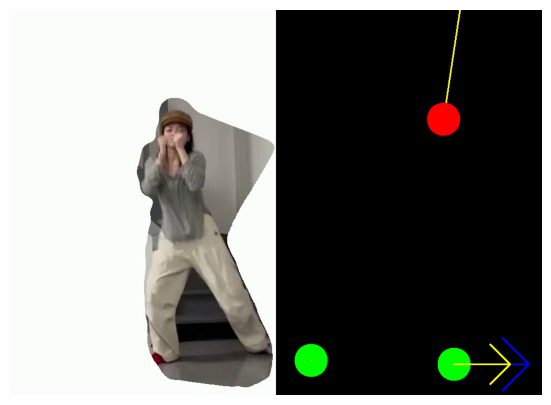

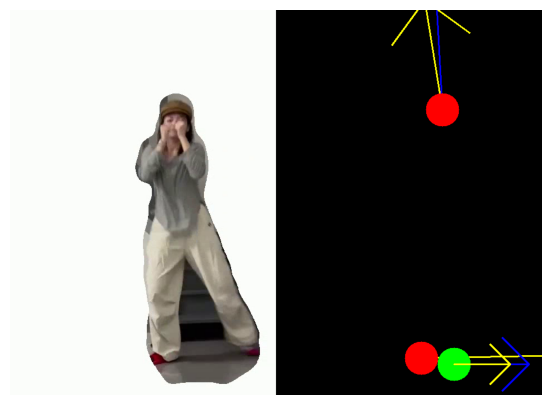

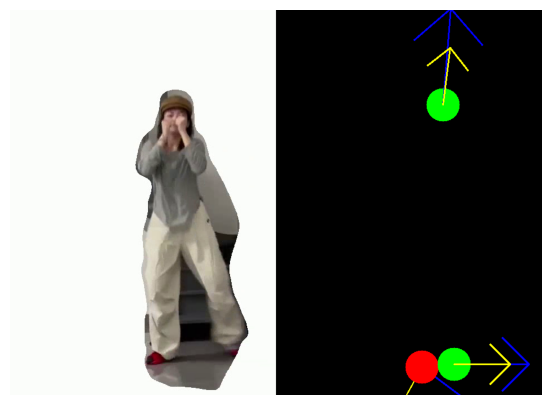

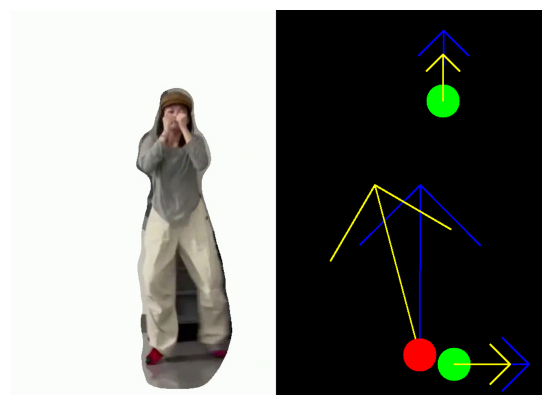

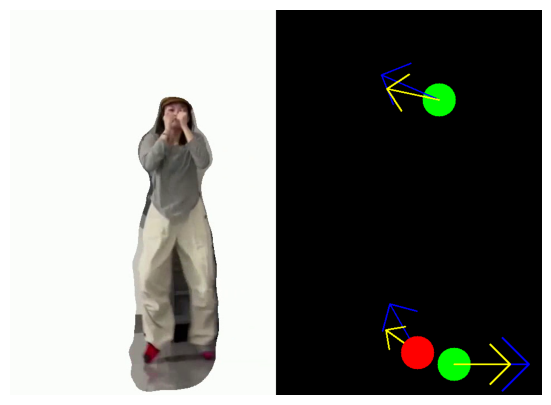

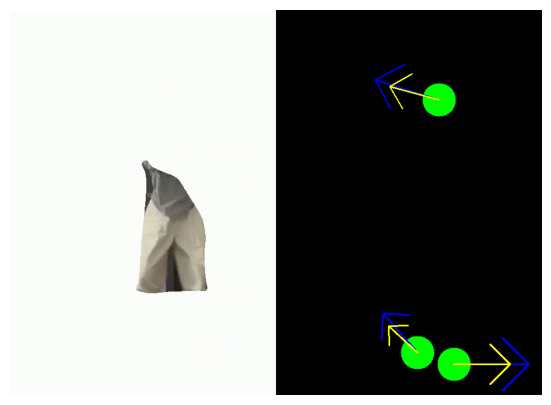

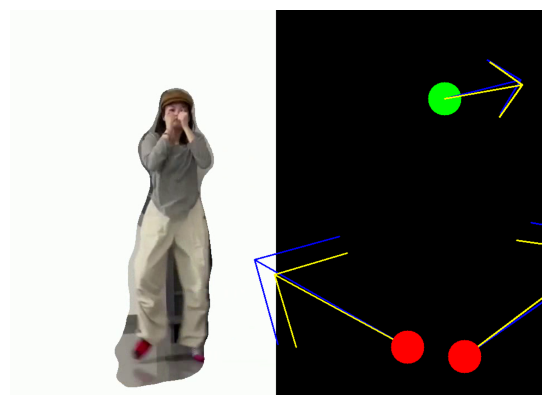

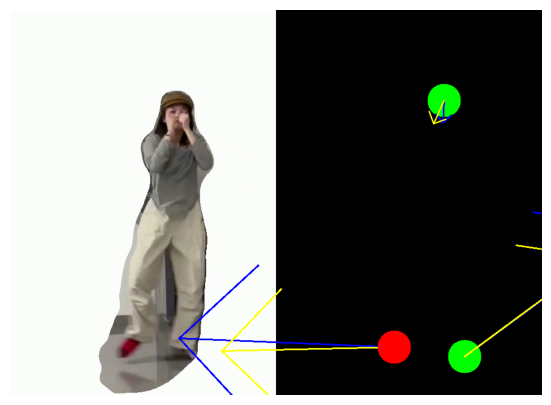

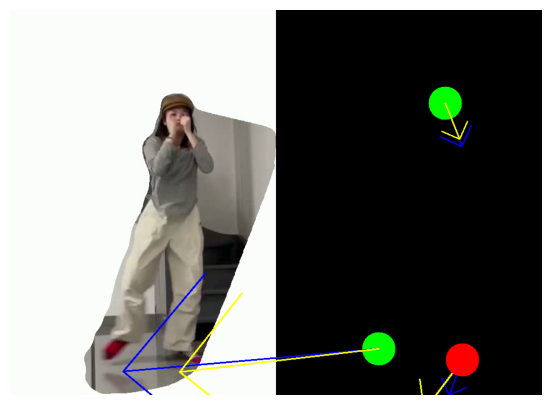

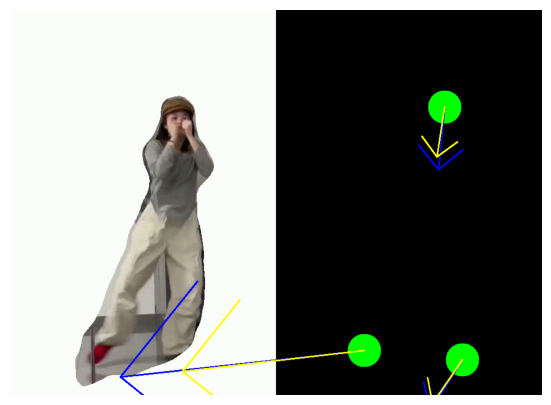

In [50]:
# Associez chaque segmenteur à son tracker
segmenters_and_trackers = [(left_shoe_segmenter, left_shoe_tracker), (right_shoe_segmenter, right_shoe_tracker), (cap_segmenter, cap_tracker)]

# Processus d'exemple
process_video(processed_video_path, segmenters_and_trackers, display_mode='static')  # Ou 'video' pour l'affichage vidéo
